<a href="https://colab.research.google.com/github/artms-18/ML-Projects/blob/main/transder_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning with TensorFlow

In [1]:
# Checl to see if we're using a GPU

!nvidia-smi

Tue Jun  8 23:13:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

Downloading helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-06-08 23:13:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-08 23:13:49 (93.9 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 Dataset 

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2021-06-08 23:13:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 74.125.137.128, 2607:f8b0:4023:c0b::80
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G   179MB/s    in 8.5s    

2021-06-08 23:14:00 (183 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [5]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macaroni_and_cheese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/apple_pie'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/escargots'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lasagna'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/scallops'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/panna_cotta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_roll_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pad_thai'.
There are 0 directories 

In [6]:
# Setup data inputs

import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = 'categorical',
                                                                                image_size = IMG_SIZE)
test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                               label_mode = 'categorical',
                                                                               image_size = IMG_SIZE,
                                                                               shuffle = False) #don't shuffle test data for image analysis

                                                                

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big model with transfer learning on 10% of 101 food classes

Here are the steps:
* Create a ModelCheckpoing create_tensorboard_callback
* Create a data sugmentation layer to build data sugmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create out own output layer)
* Compile out model
* Feature extract for 5 full passes (5 epochs on the train dataset and validation on 15% of test data to save epoch time)

In [7]:
# Create checkpoint callback

checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = "val_accuracy",
                                                         save_best_only = True)

In [8]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data Augmentation

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 and 1, required for models like ResNet50

], name = 'data_augmentation')

In [11]:
# Setup the base model and freeze its layers (this will extract features)

base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False # freezes patterns

# Setup model architecture with trainable top layers
inputs = layers.Input(shape = (224,224,3), name = "input_layer")
x = data_augmentation(inputs) #augement images (only happens during training phase)
x = base_model(x, training = False) # put model in inference mode so weight that need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name = "global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax", name = "output_layer")(x)
model = tf.keras.Model(inputs, outputs)


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [13]:
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

#Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs = 5,
                                           validation_data = test_data_all_10_percent,
                                           callbacks = checkpoint_callback)

Epoch 1/5
237/237 [==============================] - 196s 679ms/step - loss: 3.4761 - accuracy: 0.2457 - val_loss: 2.4498 - val_accuracy: 0.4406
Epoch 2/5
237/237 [==============================] - 140s 591ms/step - loss: 2.3405 - accuracy: 0.4647 - val_loss: 2.0107 - val_accuracy: 0.5082
Epoch 3/5
237/237 [==============================] - 137s 578ms/step - loss: 1.9669 - accuracy: 0.5316 - val_loss: 1.8501 - val_accuracy: 0.5311
Epoch 4/5
237/237 [==============================] - 133s 559ms/step - loss: 1.7564 - accuracy: 0.5749 - val_loss: 1.7719 - val_accuracy: 0.5418
Epoch 5/5
237/237 [==============================] - 129s 543ms/step - loss: 1.5953 - accuracy: 0.6081 - val_loss: 1.7206 - val_accuracy: 0.5526


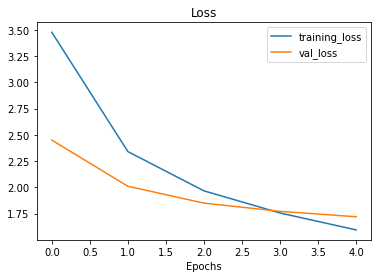

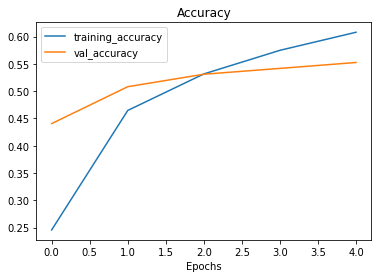

In [14]:
plot_loss_curves(history_all_classes_10_percent)

## Visualizing predictions on custom images

Now, this is the real test, how does out model go on food images not even in our test dataset (images of our own, we'll see this later on).

To visualize our model's prediction on our own images, we'll need a function to load and preprocess images, specifically it will need to:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a tensro to be the same size as the images
* Resize the image tensor 
*Scale the image


In [15]:
# Create a function to load and prepare images

def load_and_prep_image(filename, img_shape = 224, scale = True):
  """
  Reading in an image from filename, turns it into a tensor and reshapes into specified shape (img_shape, img_shape, color_channels = 3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels = 3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/no
  if scale:
    # rescale the image (get all vlaues between 0 and 1)
    return img/255
  else:
    return img # don't need to resclae images for efficient net

Now we've got a functino to load and prepare target images, let's now write some code to visualize images, their target label and our models predictions.
Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make prediction on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probabilityMM

In [ ]:
import os
import random

plt.figure(figsize = (17,10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale = False)
  print(img.shape)
  img_expanded = tf.expand_dims(img, axis = 0)
  pred_prob = model.predict(img_expanded)
  pred_class = class_names[pred_prob.argmax()]

  # plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/225.) # remember we never normalized due to nature of efficientnet model
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)